Adjusting ResNet architecture for use with CIFAR-10 dataset. Training ResNet-18 from scratch.

Check the GPU assigned:

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Apr 21 09:28:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# install  PyTorch
!pip install torch torchvision

In [ ]:
import torch
torch.__version__

'1.8.1+cu101'

In [ ]:
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import CIFAR10
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader

## Define the model

ResNet is automatically set up for ImageNet, which has 1000 classes, with CIFAR-10, we only have 10.

In [ ]:
ResNet

torchvision.models.resnet.ResNet

In [ ]:
class Cifar10ResNet(ResNet):
    def __init__(self):
        super(Cifar10ResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(super(Cifar10ResNet, self).forward(x), dim=-1)

In [ ]:
# select the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# define the model
model = Cifar10ResNet().to(device)

In [ ]:
# view the details of the model
model

Cifar10ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=T

## Set variables

In [ ]:
epochs = 10
batch_size = 128
learning_rate = 1e-4

## Download data
Loading Cifar-10 data. Images need to be rescaled and numbers normalised.

In [ ]:
def get_data_loaders(train_batch_size, val_batch_size):
    #cifar10 = CIFAR10(download=True, train=True, root=".").train_data.float()
    
    data_transform = Compose([ Resize((224, 224)),ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

    train_loader = DataLoader(CIFAR10(download=True, root=".", transform=data_transform, train=True),
                              batch_size=train_batch_size, shuffle=True)

    val_loader = DataLoader(CIFAR10(download=False, root=".", transform=data_transform, train=False),
                            batch_size=val_batch_size, shuffle=False)
    return train_loader, val_loader

In [ ]:
# load the data to variables
train_loader, val_loader = get_data_loaders(batch_size, batch_size)


Extracting ./cifar-10-python.tar.gz to .


## Run the model

In [ ]:
# helper function
def calculate_metric(metric_fn, true_y, pred_y):
  # multi class problems need to have averaging methods
  if "average" in inspect.getfullargspec(metric_fn).args:
    return metric_fn(true_y, pred_y, average="macro")
  else:
    return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
  # a utility printing mfunction
  for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
    print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

In [ ]:
# import datetime to include in submission
from datetime import datetime

In [ ]:
start_ts = time.time()

now_start = datetime.now()
print(f"Starting training with {epochs} epochs on {now_start.strftime('%d/%m/%Y %H:%M:%S')}")


losses_train = []
losses_val = []
accuracies = []
# loss function, corss entropy works well for multi-class problems
loss_function = nn.CrossEntropyLoss()
# an optimiser
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

batches = len(train_loader)
val_batches = len(val_loader)

# training loop + eval loop
for epoch in range(epochs):
    total_loss = 0
    # progress bar
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  -------------------- 
    # set model to training
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)

        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unnecessary memory in GPU 
    if torch.cuda.is_available():
      torch.cuda.empty_cache()
    
    # ----------------- VALIDATION  -----------------
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X) # this gets the prediction from the network
            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1] # get class from networks prediction
            
            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
        
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses_train.append(total_loss/batches) # for plotting learning curve
    losses_val.append(float((val_losses/val_batches).cpu()))
    accuracies.append(sum(accuracy)/len(accuracy))
print("Training losses:")
print(losses_train)
print("Validation losses:")
print(losses_val)
print("Accuracies:")
print(accuracies)
print()
now_end = datetime.now()
print(f"Training finished at {now_end.strftime('%d/%m/%Y %H:%M:%S')}")
print(f"Training time: {(time.time()-start_ts)/60} minutes")

Starting training with 10 epochs on 21/04/2021 09:30:52


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/10, training loss: 2.019456617057781, validation loss: 1.949233889579773
	     precision: 0.5583
	        recall: 0.5154
	            F1: 0.4967
	      accuracy: 0.5183


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Epoch 2/10, training loss: 1.869341756681652, validation loss: 1.8627105951309204
	     precision: 0.6309
	        recall: 0.6040
	            F1: 0.5938
	      accuracy: 0.6068



Epoch 3/10, training loss: 1.7964708152634408, validation loss: 1.8363739252090454
	     precision: 0.6765
	        recall: 0.6288
	            F1: 0.6185
	      accuracy: 0.6303



Epoch 4/10, training loss: 1.740457018927845, validation loss: 1.7861195802688599
	     precision: 0.7130
	        recall: 0.6755
	            F1: 0.6657
	      accuracy: 0.6789



Epoch 5/10, training loss: 1.6979389413238486, validation loss: 1.7541388273239136
	     precision: 0.7345
	        recall: 0.7111
	            F1: 0.7011
	      accuracy: 0.7143



Epoch 6/10, training loss: 1.6628299326543003, validation loss: 1.7319353818893433
	     precision: 0.7481
	        recall: 0.7303
	            F1: 0.7199
	      accuracy: 0.7335



Epoch 7/10, training loss: 1.6361948651121097, validation loss: 1.7290962934494019
	     precision: 0.7548
	        recall: 0.7339
	            F1: 0.7268
	      accuracy: 0.7377



Epoch 8/10, training loss: 1.6089927208088244, validation loss: 1.728542685508728
	     precision: 0.7633
	        recall: 0.7354
	            F1: 0.7236
	      accuracy: 0.7368



Epoch 9/10, training loss: 1.5876157326466591, validation loss: 1.7325961589813232
	     precision: 0.7663
	        recall: 0.7311
	            F1: 0.7288
	      accuracy: 0.7322



Epoch 10/10, training loss: 1.5661205044182975, validation loss: 1.7307113409042358
	     precision: 0.7741
	        recall: 0.7299
	            F1: 0.7298
	      accuracy: 0.7321
Training losses:
[2.019456617057781, 1.869341756681652, 1.7964708152634408, 1.740457018927845, 1.6979389413238486, 1.6628299326543003, 1.6361948651121097, 1.6089927208088244, 1.5876157326466591, 1.5661205044182975]
Validation losses:
[1.949233889579773, 1.8627105951309204, 1.8363739252090454, 1.7861195802688599, 1.7541388273239136, 1.7319353818893433, 1.7290962934494019, 1.728542685508728, 1.7325961589813232, 1.7307113409042358]
Accuracies:
[0.5182950949367089, 0.6068037974683544, 0.6303401898734177, 0.6788963607594937, 0.7142998417721519, 0.7334849683544303, 0.7377373417721519, 0.7368473101265823, 0.7321993670886076, 0.7321004746835443]

Training finished at 21/04/2021 09:55:16
Training time: 24.391153415044148 minutes


Plot the training and validation loss

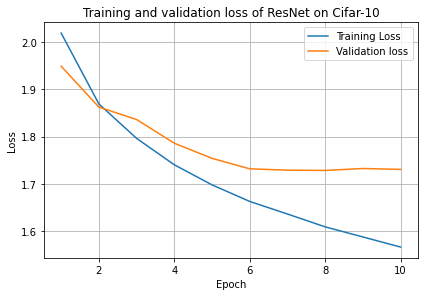

In [ ]:
import matplotlib.pyplot as plt

x = range(1,epochs+1)

plt.plot(x, losses_train, label = "Training Loss")
plt.plot(x, losses_val, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.grid(True)
plt.tight_layout()
plt.title('Training and validation loss of ResNet on Cifar-10')
plt.savefig('Cifar10_ResNet_Train.png')
plt.show()

Plot accuracy

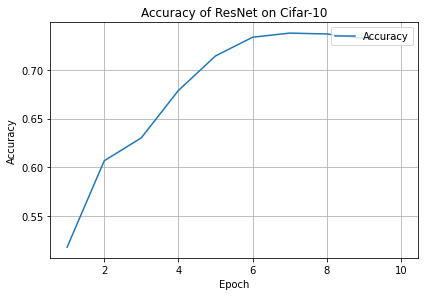

In [ ]:
import matplotlib.pyplot as plt

x = range(1,epochs+1)

plt.plot(x, accuracies, label = "Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=1)
plt.grid(True)
plt.tight_layout()
plt.title('Accuracy of ResNet on Cifar-10')
plt.savefig('Cifar10_ResNet_Accuracy.png')
plt.show()

Export values for loss and accuracy to a CSV file for later plotting/evaluation.

In [ ]:
import pandas as pd
data = {'Data': 'Cifar-10', 'Model': 'ResNet', 'Epoch': x, 'Training loss': losses_train,
     'Validation loss': losses_val, 'Accuracy': accuracies}
df = pd.DataFrame(data)
df.to_csv('Cifar10_ResNet.csv', index=False)